In [1]:
import numpy as np
from sklearn import cross_validation, datasets, linear_model, metrics

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Генерация датасета

In [3]:
data, target, coef = datasets.make_regression(n_samples=100, n_features=2, n_informative=2,
                                             n_targets=1, noise=70.0, coef=True,random_state=1)

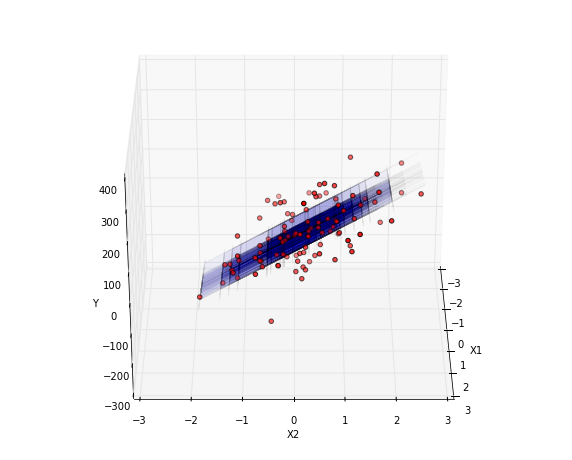

In [4]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.gca(projection='3d')


x = data[:,0]
y = data[:,1]
X,Y=np.meshgrid(x,y)
Z=X*coef[0]+Y*coef[1]
 

ax.scatter(x, y, target, zdir='z',c='red')
ax.plot_surface(X, Y, Z,rstride=4, cstride=4, color='blue',  alpha=0.01)


ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')


ax.view_init(30,360)
plt.draw()
    
    

## Разбиение данных на обучающую и тестовую выборки

In [5]:
train_data, test_data,  train_y, test_y=cross_validation.train_test_split(data, target, test_size=0.3,random_state=0)

## Обучение регрессии

Задача регрессии с MSE в качестве функционала ошибки

In [6]:
regressor=linear_model.LinearRegression()
regressor.fit(train_data,train_y)
prediction=regressor.predict(test_data)
regressor.coef_

array([ 15.71211364,  60.78190845])

Решение задачи регрессии стохастическим градиентным спуском. Можно выбрать множество параметров для настройки алгоритма

In [7]:
regressor=linear_model.SGDRegressor(loss='squared_loss', penalty='none', learning_rate='constant', eta0=0.1, random_state=10)
regressor.fit(train_data,train_y)
prediction=regressor.predict(test_data)
regressor.coef_

array([ 15.87568573,  70.33683451])

## Проверка качества модели на отложенной выборке

In [8]:
metrics.mean_squared_error(test_y,prediction)

5644.9908622625162

In [9]:
metrics.r2_score(test_y,prediction)

0.44516120948923266

## Ошибка на кросс-валидации

In [10]:
scoring=cross_validation.cross_val_score(regressor, data, target, scoring = 'mean_squared_error',cv=5)
print 'mean {}, std {}'.format(scoring.mean(), scoring.std())

mean -5895.90241247, std 2038.71385799


Получили MSE<0, но это просто означает, что  cross_val_scrore считает, что MSE - loss-function, а не score-function, и меняет  знак 

Можно определить свою метрику следующим образом:

In [11]:
my_scorer=metrics.make_scorer(metrics.mean_squared_error, greater_is_better=True)

Теперь знак меняться не будет:

In [12]:
linear_scoring = cross_validation.cross_val_score(regressor, data, target, scoring=my_scorer, 
                                                  cv = 5)
print 'mean: {}, std: {}'.format(linear_scoring.mean(), linear_scoring.std())

mean: 5895.90241247, std: 2038.71385799


## Lasso-regression

Посмотрим, как работает Lasso. Создадим выборку из двух признаков, только один из которых является значимым

In [13]:
data, target, coef=datasets.make_regression(n_features=2, n_informative=1, n_targets=1, noise=70,coef=True,random_state=1 )
print coef

[  0.          86.44794301]


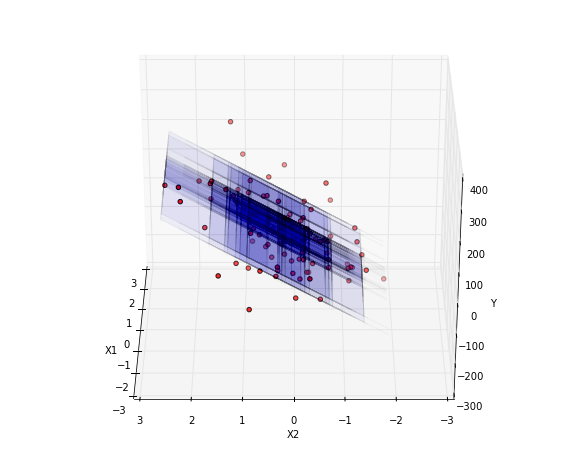

In [14]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.gca(projection='3d')


x = data[:,0]
y = data[:,1]
X,Y=np.meshgrid(x,y)
Z=X*coef[0]+Y*coef[1]
 

ax.scatter(x, y, target, zdir='z',c='red')
ax.plot_surface(X, Y, Z,rstride=4, cstride=4, color='blue',  alpha=0.01)


ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')


ax.view_init(30,180)
plt.draw()

In [15]:
train_data,test_data,train_y,test_y=cross_validation.train_test_split(data,target,test_size=0.3,random_state=1)

Сначала посмотрим на результат обучения без регуляризации

In [16]:
regressor=linear_model.LinearRegression()
regressor.fit(train_data,train_y)
prediction=regressor.predict(test_data)
print 'коэффициенты:',regressor.coef_
print 'MSE',metrics.mean_squared_error(test_y,prediction)

коэффициенты: [  3.09846206  85.69429362]
MSE 6016.19461067


In [17]:
regressor_scoring = cross_validation.cross_val_score(regressor, data, target, scoring = 'mean_squared_error', cv = 5)
print 'mean: {}, std: {}'.format(regressor_scoring.mean(), regressor_scoring.std())

mean: -5136.85662155, std: 682.020780364


Lasso с параметром регуляризации 3

In [18]:
lasso_regressor=linear_model.Lasso(alpha=3,random_state = 0)
lasso_regressor.fit(train_data, train_y)
lasso_predictions = lasso_regressor.predict(test_data)

In [19]:
lasso_scoring = cross_validation.cross_val_score(lasso_regressor, data, target, scoring = 'mean_squared_error', cv = 5)
print 'mean: {}, std: {}'.format(lasso_scoring.mean(), lasso_scoring.std())

mean: -5153.65520088, std: 694.354784699


In [20]:
print lasso_regressor.coef_

[  0.          81.19976677]


Качество на кросс-валидации стало совсем немного ниже, но с помощью lasso мы произвели отбор признаков

In [21]:
print "y = {:.2f}*x1 + {:.2f}*x2".format(coef[0], coef[1])

y = 0.00*x1 + 86.45*x2


## Выбор параметра для Lasso

best_alpha = 5.8
Полученные коэффициенты [  0.          77.68711454]


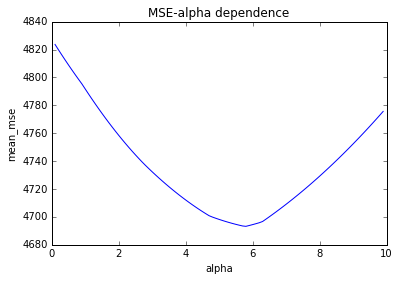

In [24]:
from sklearn.linear_model import LassoCV
#создадим массив для параметров регуляризации, из которых хотим выбрать лучший
alphas=np.arange(0.1,10,0.1)
#тестируем  модели с каждым параметром из массива с помощью CV
lasso = linear_model.LassoCV(alphas=alphas,cv=5)
lasso.fit(train_data, train_y)
#lasso.mse_path_ - значения MSE для каждого фолда и каждого параметра
means=np.mean(lasso.mse_path_,axis=1)
plt.plot(lasso.alphas_, means)
plt.xlabel("alpha")
plt.ylabel("mean_mse")
plt.title("MSE-alpha dependence")
print "best_alpha =",lasso.alpha_
print "Полученные коэффициенты", lasso.coef_
